# Drying out

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import datetime

In [2]:
feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

print(schema)

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

In [3]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:13030/nam_s/*')
df = df.select([
    'Timestamp',
    'Geohash',
    col('categorical_rain_yes1_no0_surface').alias('Rain'),
    col('categorical_snow_yes1_no0_surface').alias('Snow'),
    col('categorical_freezing_rain_yes1_no0_surface').alias('Freezing_rain'),
    col('precipitable_water_entire_atmosphere').alias('Water_atmosphere'),
    col('direct_evaporation_cease_soil_moisture_surface').alias('Soil_moisture'),
])  # Select columns needed to speed up the process
df.show(10)

+-------------+------------+----+----+-------------+----------------+-------------+
|    Timestamp|     Geohash|Rain|Snow|Freezing_rain|Water_atmosphere|Soil_moisture|
+-------------+------------+----+----+-------------+----------------+-------------+
|1438754400000|f2jv9b26m9kp| 0.0| 0.0|          0.0|       24.311327|      0.06625|
|1439748000000|c0r6zjuefu2p| 0.0| 0.0|          0.0|        20.39285|          0.0|
|1440547200000|f26y8y56pn7z| 0.0| 0.0|          0.0|       23.475079|       0.0275|
|1440460800000|dmbnfcepz1xb| 0.0| 0.0|          0.0|       55.483532|          0.0|
|1440568800000|cdqkdn3sbhup| 0.0| 0.0|          0.0|       17.907278|       0.0475|
|1440871200000|f096j2kw7980| 0.0| 0.0|          0.0|       27.725079|          0.0|
|1439920800000|d7b784wu2p0p| 0.0| 0.0|          0.0|        48.68999|   0.13499999|
|1439510400000|b9vgvezq7y00| 0.0| 0.0|          0.0|       17.061398|          0.0|
|1440439200000|9nqc8pzjhkrz| 0.0| 0.0|          0.0|       23.348156|       

In [5]:
%%time

df.select([
    'Rain',
    'Snow',
    'Freezing_rain',
    'Water_atmosphere',
    'Soil_moisture',
]).describe().show()

+-------+-------------------+--------------------+--------------------+------------------+--------------------+
|summary|               Rain|                Snow|       Freezing_rain|  Water_atmosphere|       Soil_moisture|
+-------+-------------------+--------------------+--------------------+------------------+--------------------+
|  count|          108000000|           108000000|           108000000|         108000000|           108000000|
|   mean|0.08852023148148148|0.027453277777777778|7.044629629629629E-4|21.614790792160704|0.031105355321078217|
| stddev| 0.2840499970903469| 0.16340010882570713|0.026532370821601543|14.047413945874684|0.037378546795904556|
|    min|                0.0|                 0.0|                 0.0|        0.36906433|                 0.0|
|    max|                1.0|                 1.0|                 1.0|          98.56735|          0.13499999|
+-------+-------------------+--------------------+--------------------+------------------+--------------

### Here is the camp fire in California, North America in November, 2018 that costed over 80 lifes.

#### Let's find out which was the driest month in this location.

* Camp fire actural location: [\(source\)](https://www.npr.org/2018/11/25/670652466/northern-california-camp-fire-contained)

\(I just wish I could view image on Twitter!\)

![camp_fire](img/camp_fire.png)

* Camp fire location geohashes: (9r16, 9r13, 9r19, 9r1d)

![camp_fire](img/camp_fire_geohash.png)

### Converting timestamp to month

In [7]:
%%time

df = df.withColumn('Timestamp', df['Timestamp'] / 1000)\
    .withColumn('Month', month(from_unixtime('Timestamp').cast(DateType())))
df.show(2)

+-----------+------------+----+----+-------------+----------------+-------------+-----+
|  Timestamp|     Geohash|Rain|Snow|Freezing_rain|Water_atmosphere|Soil_moisture|Month|
+-----------+------------+----+----+-------------+----------------+-------------+-----+
|1.4387544E9|f2jv9b26m9kp| 0.0| 0.0|          0.0|       24.311327|      0.06625|    8|
| 1.439748E9|c0r6zjuefu2p| 0.0| 0.0|          0.0|        20.39285|          0.0|    8|
+-----------+------------+----+----+-------------+----------------+-------------+-----+
only showing top 2 rows

CPU times: user 21.6 ms, sys: 5.23 ms, total: 26.8 ms
Wall time: 3min 8s


In [9]:
%%time

df.createOrReplaceTempView("TINY_NAM")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Rain) AS avg_rain,
        AVG(Snow) AS avg_snow,
        AVG(Freezing_rain) AS avg_freezing_rain,
        AVG(Water_atmosphere) AS avg_water_atmosphere,
        AVG(Soil_moisture) AS avg_soil_moisture
    FROM TINY_NAM
    WHERE Geohash like "9r16%"
        OR Geohash like "9r13%"
        OR Geohash like "9r19%"
        OR Geohash like "9r1d%"
    GROUP BY Month
    '''
)
avg.show()

+-----+--------------------+--------------------+-----------------+--------------------+-------------------+
|Month|            avg_rain|            avg_snow|avg_freezing_rain|avg_water_atmosphere|  avg_soil_moisture|
+-----+--------------------+--------------------+-----------------+--------------------+-------------------+
|   12|   0.231433506044905|0.010362694300518135|              0.0|   13.98869035610469|0.07402849364671889|
|    1|0.022222222222222223|                 0.0|              0.0|  13.053256724023411|0.07382050909293003|
|    6| 0.00686106346483705|                 0.0|              0.0|   19.34848829403545|0.07491852109213432|
|    3|0.017391304347826087|                 0.0|              0.0|  12.671059799194335|0.07405651797419009|
|    5|0.020512820512820513|                 0.0|              0.0|   16.85481702201387|0.07550426964831149|
|    9|0.006644518272425249|                 0.0|              0.0|  17.046607142667042|0.07474667395765203|
|    4| 0.070796460

In [10]:
avg.show()

+-----+--------------------+--------------------+-----------------+--------------------+-------------------+
|Month|            avg_rain|            avg_snow|avg_freezing_rain|avg_water_atmosphere|  avg_soil_moisture|
+-----+--------------------+--------------------+-----------------+--------------------+-------------------+
|   12|   0.231433506044905|0.010362694300518135|              0.0|   13.98869035610469|0.07402849364671889|
|    1|0.022222222222222223|                 0.0|              0.0|  13.053256724023411|0.07382050909293003|
|    6| 0.00686106346483705|                 0.0|              0.0|   19.34848829403545|0.07491852109213432|
|    3|0.017391304347826087|                 0.0|              0.0|  12.671059799194335|0.07405651797419009|
|    5|0.020512820512820513|                 0.0|              0.0|   16.85481702201387|0.07550426964831149|
|    9|0.006644518272425249|                 0.0|              0.0|  17.046607142667042|0.07474667395765203|
|    4| 0.070796460

In [11]:
avg_pandas_df = avg.toPandas()
avg_pandas_df

,Month,avg_rain,avg_snow,avg_freezing_rain,avg_water_atmosphere,avg_soil_moisture
0,12,0.231434,0.010363,0.0,13.988690,0.074028
1,1,0.022222,0.000000,0.0,13.053257,0.073821
2,6,0.006861,0.000000,0.0,19.348488,0.074919
3,3,0.017391,0.000000,0.0,12.671060,0.074057
4,5,0.020513,0.000000,0.0,16.854817,0.075504
5,9,0.006645,0.000000,0.0,17.046607,0.074747
6,4,0.070796,0.010619,0.0,13.490222,0.073666
7,8,0.003460,0.000000,0.0,17.596158,0.075737
8,7,0.012963,0.000000,0.0,24.211955,0.073803
9,10,0.013559,0.000000,0.0,18.354356,0.074032


In [12]:
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

,Month,avg_rain,avg_snow,avg_freezing_rain,avg_water_atmosphere,avg_soil_moisture
1,1,0.022222,0.000000,0.0,13.053257,0.073821
11,2,0.097173,0.000000,0.0,14.472574,0.073523
3,3,0.017391,0.000000,0.0,12.671060,0.074057
6,4,0.070796,0.010619,0.0,13.490222,0.073666
4,5,0.020513,0.000000,0.0,16.854817,0.075504
2,6,0.006861,0.000000,0.0,19.348488,0.074919
8,7,0.012963,0.000000,0.0,24.211955,0.073803
7,8,0.003460,0.000000,0.0,17.596158,0.075737
5,9,0.006645,0.000000,0.0,17.046607,0.074747
9,10,0.013559,0.000000,0.0,18.354356,0.074032


In [30]:
avg_pandas_df.to_pickle('/home4/csung4/avg_pandas_df.pickle')

In [2]:
avg_pandas_df = pd.read_pickle('/home4/csung4/avg_pandas_df.pickle')

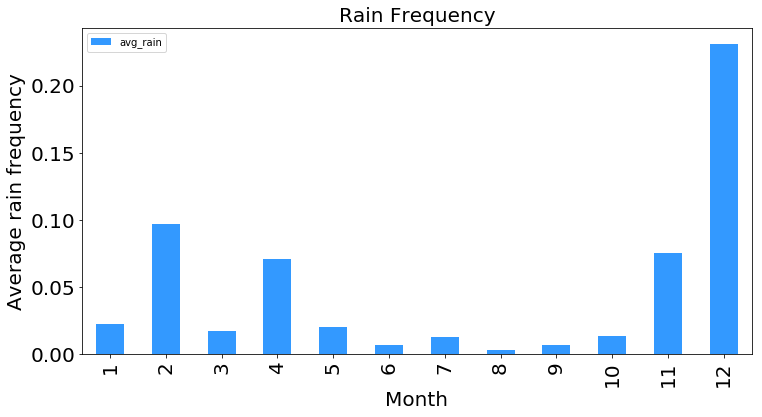

In [3]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='avg_rain',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Average rain frequency', fontsize = 20)
ax.set_title('Rain Frequency', fontsize = 20)
plt.show()

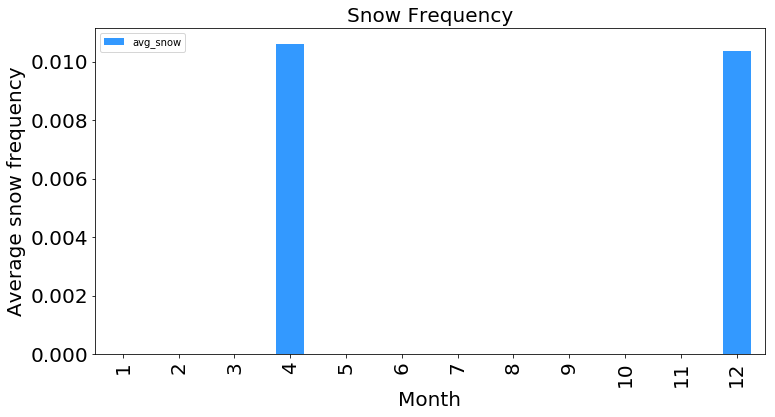

In [4]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='avg_snow',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Average snow frequency', fontsize = 20)
ax.set_title('Snow Frequency', fontsize = 20)
plt.show()

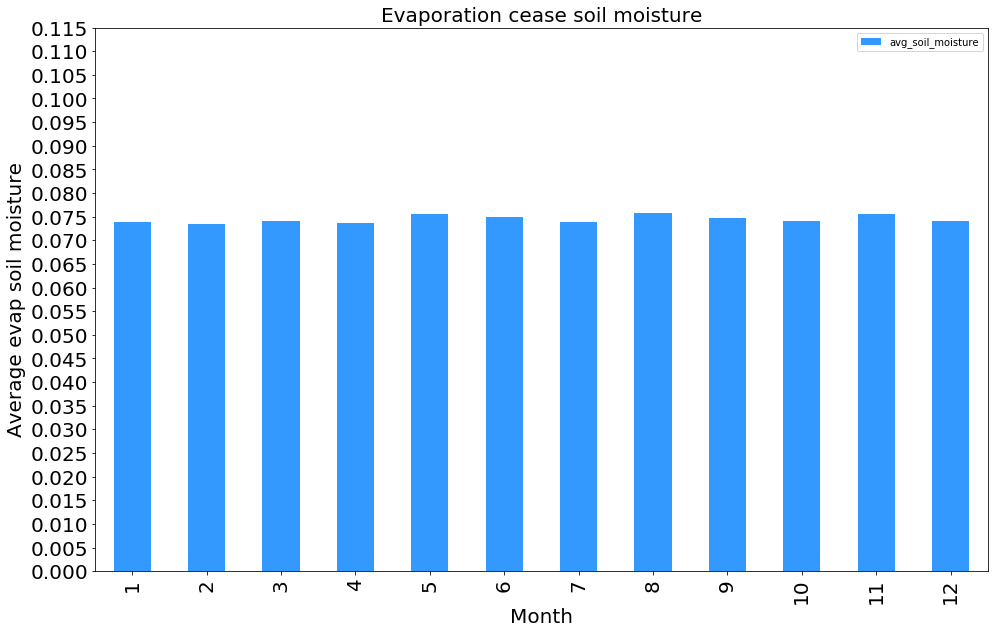

In [17]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(16, 10),
    x='Month',
    y='avg_soil_moisture',
    fontsize = 20,
    color='#3399ff',
    yticks=np.arange(0, 0.12, 0.005)
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Average evap soil moisture', fontsize = 20)
ax.set_title('Evaporation cease soil moisture', fontsize = 20)
plt.show()

In [18]:
avg_pandas_df.describe()

,Month,avg_rain,avg_snow,avg_freezing_rain,avg_water_atmosphere,avg_soil_moisture
count,12.000000,12.000000,12.000000,12.0,12.000000,12.000000
mean,6.500000,0.048197,0.001749,0.0,16.107567,0.074453
std,3.605551,0.065706,0.004084,0.0,3.506996,0.000808
min,1.000000,0.003460,0.000000,0.0,12.202616,0.073523
25%,3.750000,0.011437,0.000000,0.0,13.380981,0.073816
50%,6.500000,0.018952,0.000000,0.0,15.663695,0.074044
75%,9.250000,0.071933,0.000000,0.0,17.785707,0.075065
max,12.000000,0.231434,0.010619,0.0,24.211955,0.075737


In [19]:
avg_pandas_df

,Month,avg_rain,avg_snow,avg_freezing_rain,avg_water_atmosphere,avg_soil_moisture
1,1,0.022222,0.000000,0.0,13.053257,0.073821
11,2,0.097173,0.000000,0.0,14.472574,0.073523
3,3,0.017391,0.000000,0.0,12.671060,0.074057
6,4,0.070796,0.010619,0.0,13.490222,0.073666
4,5,0.020513,0.000000,0.0,16.854817,0.075504
2,6,0.006861,0.000000,0.0,19.348488,0.074919
8,7,0.012963,0.000000,0.0,24.211955,0.073803
7,8,0.003460,0.000000,0.0,17.596158,0.075737
5,9,0.006645,0.000000,0.0,17.046607,0.074747
9,10,0.013559,0.000000,0.0,18.354356,0.074032


* For the rain/snow frequency, August is the lowest month.
* For evaporation cease soil moisture, August is the highest one. Moreover, the more water evaporation from soil means the drier the air is.
* August is the driest month for that region.
* Although rain frequency indicates that November is more rainy. However the data only show if it rain or not instead of the amount of rain. So, as we can tell from evaporation cease soil moisture, November is the second driest month. That might be the reason it's very easy to spread fire during November.